<a href="https://colab.research.google.com/github/micheusch/sagemaker/blob/main/imdb_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using the TextVectorization layer

In [1]:
import string
import re
import string
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [ ]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [ ]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


In [ ]:
text_vectorization = TextVectorization(
    output_mode="int",
)

In [ ]:
def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

In [ ]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)

**Displaying the vocabulary**

In [ ]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)


In [ ]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


### Load the IMDB movie reviews data

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.7M      0  0:00:07  0:00:07 --:--:-- 16.2M


In [2]:
!tar -xf aclImdb_v1.tar.gz

In [3]:
!rm -r aclImdb/train/unsup

In [4]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [5]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    if not os.path.isdir(val_dir / category):
      os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

In [6]:
import pandas as pd
df_train = pd.DataFrame(columns={'text', 'label'})
for i, category in enumerate(("neg", "pos")):
    files = os.listdir(train_dir / category)
    for f in files:
        ft = open(train_dir / category / f, "r")
        df_train = df_train.append(pd.DataFrame({'text':[ft.read()], 'label':[i]}))

In [7]:
df_val = pd.DataFrame(columns={'text', 'label'})
for i, category in enumerate(("neg", "pos")):
    files = os.listdir(val_dir / category)
    for f in files:
        ft = open(val_dir / category / f, "r")
        df_val = df_val.append(pd.DataFrame({'text':[ft.read()], 'label':[i]}))

In [8]:
df_train.shape, df_val.shape

((20000, 2), (5000, 2))

#### EDA

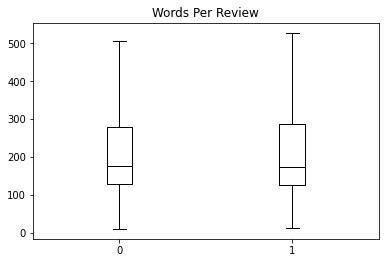

In [9]:
import matplotlib.pyplot as plt
df_train["Words Per Review"] = df_train["text"].str.split().apply(len)
df_train.boxplot("Words Per Review", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [10]:
df_train["text"].str.split().apply(len).describe()

count    20000.000000
mean       233.332800
std        173.154448
min         10.000000
25%        127.000000
50%        174.000000
75%        283.000000
max       2470.000000
Name: text, dtype: float64

### Prepare Datasets

#### Keras Dataset

In [14]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [15]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'There is no possible reason I can fathom why this movie was ever made.<br /><br />Why must Hollywood continue to crank out one horrible update of a classic after another? ( Cases in point: Mister Magoo, The Avengers - awful! )<br /><br />Christopher Lloyd, whom I normally enjoy, was so miserably miscast in this role. His manic portrayal of our beloved "Uncle Martin" is so unspeakably unenjoyable to be almost criminal. His ranting, groaning, grimacing and histrionics provide us with no reason to care for his character except as some 1 dimensional cartoon character.<br /><br />The director must have thought that fast movements, screaming dialogue and "one-take" slapstick had some similarity to comedy. Apparently he told EVERY ACTOR to act as if they had red ants in their pants.<br /><br />Fault must lie with the irresponsibly wrought script. I think the writer u

#### HF Dataset

In [11]:
!pip install datasets --quiet

In [12]:
from datasets import Dataset, DatasetDict
train_ds = Dataset.from_pandas(df_train, preserve_index = False)
valid_ds = Dataset.from_pandas(df_val, preserve_index = False)

In [13]:
from datasets import Dataset, DatasetDict
ds = DatasetDict()

ds['train'] = train_ds
ds['validation'] = valid_ds

## Two approaches for representing groups of words: Sets and sequences

### LogisticRegression TfIdf Baseline

In [35]:
!pip install eli5 --quiet

     |████████████████████████████████| 106 kB 4.2 MB/s 


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import seaborn as sns
import eli5

In [37]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)

In [38]:
X_train_text = text_transformer.fit_transform(df_train['text'])
X_test_text = text_transformer.transform(df_val['text'])

In [39]:
df_train['label'] = df_train['label'].astype('int')
df_val['label'] = df_val['label'].astype('int')

In [40]:
X_train_text.shape, X_test_text.shape

((20000, 150000), (5000, 150000))

In [41]:
logit = LogisticRegression(C=10e1, solver='lbfgs',  random_state=17, n_jobs=4)

In [42]:
%%time
logit.fit(X_train_text, df_train['label'].values)

CPU times: user 142 ms, sys: 436 ms, total: 579 ms
Wall time: 8.2 s


LogisticRegression(C=100.0, n_jobs=4, random_state=17)

In [43]:
from sklearn.metrics import accuracy_score

pred_train = logit.predict(X_train_text)
pred_test = logit.predict(X_test_text)

accuracy_score(df_val['label'].values, pred_test)

0.9022

In [44]:
eli5.show_weights(estimator=logit, 
                  feature_names= list(text_transformer.get_feature_names()),
                  top=(10, 10))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+17.898,great
+16.350,excellent
+14.732,perfect
+14.623,best
+12.851,wonderful
+12.497,favorite
+11.688,amazing
+11.676,today
+11.408,funniest
+11.358,superb


### Bag-of-words models

#### Single words (unigrams) with binary encoding

**Preprocessing our datasets with a `TextVectorization` layer**

In [ ]:
text_vectorization = TextVectorization(
    max_tokens=20000,
    # standardize="lower_and_strip_punctuation",
    output_mode="multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Inspecting the output of our binary unigram dataset**

In [ ]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


**Our model-building utility**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

**Training and testing the binary unigram model**

In [ ]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
history = model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.4069 - accuracy: 0.8309 - val_loss: 0.2893 - val_accuracy: 0.8878
Epoch 2/10
625/625 [=======================

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Bigrams with binary encoding

**Configuring the `TextVectorization` layer to return bigrams**

In [34]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

NameError: ignored

**Training and testing the binary bigram model**

In [ ]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

#### Bigrams with TF-IDF encoding

**Configuring the `TextVectorization` layer to return token counts**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

**Configuring `TextVectorization` to return TF-IDF-weighted outputs**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

**Training and testing the TF-IDF bigram model**

In [ ]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

In [ ]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

# Feature extraction

In [14]:
!pip install transformers[tf,torch,sentencepiece,optuna,sklearn,onnxruntime]==4.11.3 --quiet

In [15]:
import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import torch
import transformers

In [16]:
# hide_output
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Tokenize

In [17]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [19]:
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
ds_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [17]:
# hide_output
train_encoded = train_ds.map(tokenize, batched=True, batch_size=None)
valid_encoded = valid_ds.map(tokenize, batched=True, batch_size=None)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
train_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
valid_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

#### Train LR on hidden_states

In [ ]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [14]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [19]:
train_hidden = train_encoded.map(extract_hidden_states, batched=True, batch_size=256)

  0%|          | 0/79 [00:00<?, ?ba/s]

In [24]:
valid_hidden = valid_encoded.map(extract_hidden_states, batched=True, batch_size=256)

  0%|          | 0/20 [00:00<?, ?ba/s]

In [28]:
import numpy as np

# X_train = np.array(train_hidden["train"]["hidden_state"])
# X_valid = np.array(train_hidden["validation"]["hidden_state"])
# y_train = np.array(valid_hidden["train"]["label"])
# y_valid = np.array(valid_hidden["validation"]["label"])
# X_train.shape, X_valid.shape
X_train = np.array(train_hidden["hidden_state"])
X_valid = np.array(valid_hidden["hidden_state"])
y_train = np.array(train_hidden["label"])
y_valid = np.array(valid_hidden["label"])
X_train.shape, X_valid.shape

((20000, 768), (5000, 768))

In [32]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
lr_clf.score(X_valid, y_valid)

0.8814

# Fine tune with PT

In [21]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [22]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [23]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(ds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-imdb"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [24]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.272900,0.228120,0.910800,0.910630
2,0.149400,0.253150,0.926200,0.926200


In [25]:
os.makedirs("models")
model.save_pretrained("models")

In [27]:
!gzip models/pytorch_model.bin

In [28]:
# hide_output
preds_output = trainer.predict(ds_encoded["validation"])

In [29]:
preds_output.metrics

{'test_accuracy': 0.9262,
 'test_f1': 0.9261999734319903,
 'test_loss': 0.25315046310424805,
 'test_runtime': 160.0052,
 'test_samples_per_second': 31.249,
 'test_steps_per_second': 1.956}

In [31]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)

In [35]:
y_train = np.array(ds["train"]["label"])
y_valid = np.array(ds["validation"]["label"])

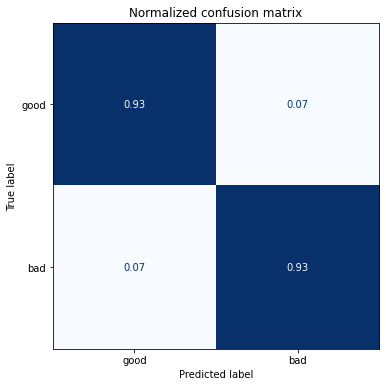

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, ['good','bad'])

#### Error analysis

In [39]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [40]:
# Convert our dataset back to PyTorch tensors
ds_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_encoded["validation"] = ds_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/313 [00:00<?, ?ba/s]

In [44]:
ds_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = ds_encoded["validation"][:][cols]
# df_test["label"] = df_test["label"].apply(label_int2str)
# df_test["predicted_label"] = (df_test["predicted_label"]
#                               .apply(label_int2str))
df_test["label"] = df_test["label"]
df_test["predicted_label"] = df_test["predicted_label"]

In [48]:
# https://www.codegrepper.com/code-examples/python/pandas+set+option+max+columns
pd.set_option('display.max_colwidth', 150)

In [49]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
685,"This sleek, sexy movie is a must-see. Only upon multiple viewings can one truly understand the uniqueness of this film. Personally I enjoy the nar...",0,1,6.139193
457,"this one of the best celebrity's reality shows a ever saw. we can see the concerts we can see the life of Britney, i love the five episodes. i was...",0,1,6.037980
2174,"Although this isn't a ""great film,"" there's something compelling and memorable about it. Like another commenter on the film, I saw this in childho...",0,1,6.019410
4497,"Time for a rant, eh: I thought Spirit was a great movie to watch. However, there were a few things that stop me from rating it higher than a 6 or ...",1,0,6.018079
2877,"This movie is stuffed full of stock Horror movie goodies: chained lunatics, pre-meditated murder, a mad (vaguely lesbian) female scientist with an...",1,0,5.984630
2719,"Sure it was well shot and made, very well shot and made! But the story was just so weak. And the portrayal of Lincoln was even weaker. Not that He...",1,0,5.956360
2049,this is a great movie. I love the series on tv and so I loved the movie. One of the best things in the movie is that Helga finally admits her deep...,0,1,5.952012
109,"In 17th Century Japan, there lived a samurai who would set the standard for the ages. His name was Mayeda. He is sent on an epic journey across th...",0,1,5.935352
4988,Its time to pay tribute to the great Charton Heston after his recent passing but this film is not the one. His other films of a past generation we...,1,0,5.921838
693,"I was unsure whether or not Andy Sidaris could repeat his success with the cinematic hit ""Malibu Express."" With his film Fit to Kill he has proved...",0,1,5.838680


In [51]:
df_test.iloc[685].text

"This sleek, sexy movie is a must-see. Only upon multiple viewings can one truly understand the uniqueness of this film. Personally I enjoy the narrator for his intelligent, no subject left untouched, style of narration. The introduction grips you right away, and holds you at the edge of your seat throughout the film. He provides wonderful insight into the world of the trainables and allows the audience to really 'connect' with internal horror this film exhibits. The script itself holds the movie together wonderfully. Not only for kids, but the elderly alike will gain a higher understanding of the trainables and the modern grasp that they have on the sexual experience. Ahead of its time and groundbreaking in cinematography, it surely defines the word 'masterpiece'."

In [52]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
4655,"This is a beautiful film. The true tale of bond between father and son. This is by far, Tom Hanks at his finest. Tom Hanks is really out of the bo...",1,1,0.001984
3455,"Loosely based on the James J Corbett biography ""The Roar Of The Crowd"", Gentleman Jim is a wonderfully breezy picture that perfectly encapsulates ...",1,1,0.002016
4434,"I have always been a fan of David Lynch and with this film Lynch proved to critics that he has the talent, style, and artistic integrity to make f...",1,1,0.002032
3447,"'Ned Kelly' is a wonderfully made Australian film honouring a true Australian hero. We are taken into the world of Ned, his best friend, Joe Byrne...",1,1,0.002033
4161,Paul Verhoeven's predecessor to his breakout hit 'Basic Instinct' is a stylish and shocking neo-noir thriller. Verhoeven has become known for maki...,1,1,0.002049
4132,I somehow missed this movie when it came out and have discovered it as late as last week thanks to a friend's recommendation. I can honestly say t...,1,1,0.002051
4311,"The year 1995, when so many people talked about the great premiere of BRAVEHEART by Mel Gibson, also saw another very fine, yet underrated movie o...",1,1,0.002060
3373,"By some happy coincidence the same year that Jimmy Stewart and Kim Novak made Alfred Hitchcock's haunting masterpiece ""Vertigo"", they also made th...",1,1,0.002066
3081,"""Moonstruck"" is a movie that I liked the first time I watched it. I really liked it the second time. I loved it the third time. Now it is one of m...",1,1,0.002070
3982,I originally came across Linda Feferman's Seven Minutes in Heaven when I was 14 and worked at a video store and I loved it. I recently watched the...,1,1,0.002079


In [53]:
#hide_output
from transformers import pipeline

In [55]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [56]:
custom_review = "I saw a movie today and it was really good."
preds = classifier(custom_review, return_all_scores=True)

RuntimeError: ignored